In [40]:
import sys
sys.path.insert(0, "../netml/src/")
import pandas as pd
import numpy as np
from netml.pparser.parser import PCAP
import json
import re
import ast
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os, glob
import seaborn as sns, matplotlib.pyplot as plt

In [88]:
%run "../scripts/helper_functions.py"

In [89]:
dirname = "../logs_Meet_05-04/"
webrtc_files = glob.glob(f"{dirname}webrtc/*.json")
file_map = {}
cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker','rtp.padding','rtp.ext','rtp.ext.len','rtcp.pt','rtcp.senderssrc','rtcp.ssrc.high_seq','rtcp.ssrc.dlsr','rtcp.psfb.fmt', 'rtcp.rtpfb.fmt','rtcp.sender.octetcount']
for webrtc_filename in webrtc_files:
    pref = os.path.basename(webrtc_filename)
    net_filename = f"{dirname}capture/{pref[:-4]}csv"
    if not os.path.exists(net_filename):
        continue

    df_all = get_webrtc(webrtc_filename)
    if df_all.empty:
        continue
    dur  = df_all["ts"].max() - df_all["ts"].min()
    if dur < 85:
        print("webrtc too short..skipping %s" % webrtc_filename)
        continue

    ip = '192.168.1.107'
    df_net = pd.read_csv(net_filename, header=None, sep='\t', names=cols)
    time_col = "frame.time_epoch"
    dur = df_net[time_col].max() - df_net[time_col].min()
    if dur > 150:
        print("capture is too long..skipping %s" % webrtc_filename) 
        continue
    df1 = df_net[(df_net["ip.dst"] == ip) & (~pd.isna(df_net["rtp.ssrc"]))]
    file_map[pref] = {"webrtc": df_all, "pcap": df1}  

no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream


/tmp/ipykernel_939785/3749908963.py:20: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_net = pd.read_csv(net_filename, header=None, sep='\t', names=cols)


capture is too long..skipping ../logs_Meet_05-04/webrtc/1006_296_69046_26895_42_1651708146.json
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
capture is too long..skipping ../logs_Meet_05-04/webrtc/100_35_8122_2915_44_1651711036.json
no inbound stream
no inbound stream
no inbound stream
no inbound stream
webrtc too short..skipping ../logs_Meet_05-04/webrtc/110_36_8069_1926_40_1651712555.json
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
webrtc too short..skipping ../logs_Meet_05-04/webrtc/8218_1205_23077_5088_51_1651734925.json
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
no inbound stream
webrtc too short..skipping ../logs_Meet_05-04/webrtc/3681_723_37545_22329_2_1651724365.json
webrtc too short..skipping ../logs_Meet_05-04/webrtc/1064_204_35529_18

In [112]:
df_list = []
i = 0
for k in file_map:
    df_net = file_map[k]['pcap']
    df_video = df_net[df_net["rtp.p_type"] == "98"]
    df_video = df_video.groupby("rtp.timestamp").agg({"udp.length": "sum", "frame.time_epoch": ["min", "max"]}).reset_index()
    df_video.columns = ['_'.join(col).strip('_') for col in df_video.columns.values]
    df_video["ft_end"] = df_video['frame.time_epoch_max'].apply(lambda x: int(x))
    df_webrtc = file_map[k]['webrtc']
    df_grp = df_video.groupby("ft_end")["udp.length_sum"].agg("count").reset_index()
    df_grp = df_grp.rename(columns={'udp.length_sum': 'fps'})
    df_merge = pd.merge(df_grp, df_webrtc, left_on="ft_end", right_on="ts")
    df_merge  = df_merge.tail(df_merge.shape[0] -2)
    df_merge  = df_merge.head(df_merge.shape[0] -2)
    df_list.append(df_merge)

df_merge = pd.concat(df_list).reset_index()
df_merge = df_merge[~pd.isna(df_merge['framesPerSecond'])]

In [93]:
from sklearn.metrics import mean_squared_error

In [111]:
y_actual = df_merge["framesReceived"].tolist()
y_predict = df_merge["fps"].tolist()
y_actual1 = df_merge["framesPerSecond"].tolist()
print(mean_squared_error(y_actual, y_predict, squared="False"))
print(mean_squared_error(y_actual1, y_predict, squared="False"))

5.805327148780659
2.7741232693794364


In [105]:
print(len(y_actual))

14833


In [ ]:
sns.scatterplot(data=df_merge, x="ts", y="")

In [ ]:
file_map[k]['web]

In [58]:
df_video = df_net[df_net["rtp.p_type"] == "111"]
df_video.groupby("rtp.timestamp").agg({"udp.length": "sum", "frame.time_epoch": ["min", "max"]})

Empty DataFrame
Columns: [(udp.length, sum), (frame.time_epoch, min), (frame.time_epoch, max)]
Index: []

In [41]:
feature_map = {}
audio_size = 100
for k in file_map:
    df_net = file_map[k]['pcap']
    df_net = df_net[df_net['udp.length'] > audio_size]
    df_stat = get_net_stats(df_net)
    feature_map[k] = {}
    feature_map[k]['pcap'] = df_stat
    feature_map[k]['webrtc'] = file_map[k]['webrtc']

In [42]:
df_list = []
for filename in feature_map:
    df_all = feature_map[filename]["webrtc"]
    df1 = feature_map[filename]["pcap"]
    #print(df1["time_win"].max() - df1["time_win"].min(), df_all["ts"].max() - df_all["ts"].min())
    df_merge = pd.merge(df_all, df1, left_on="ts", right_on="time_win")
    df_merge["filename"] = filename
    df_list.append(df_merge)
df_merge = pd.concat(df_list).reset_index()

In [44]:
cols_x = ['bitrate_kbps', 'pktrate_pps',
       'size_min', 'size_max', 'size_mean', 'size_std', 'size_q1', 'size_q2',
       'size_q3', 'iat_min', 'iat_max', 'iat_mean', 'iat_std', 'iat_q1',
       'iat_q2', 'iat_q3']

cols_y = ['framesPerSecond', '[bytesReceived_in_bits/s]', 'freezeCount*', 'totalFreezesDuration*']
df_small = df_merge[cols_x + cols_y]

In [46]:
df_small['bitrate_kbps'].shape

(14835,)

(0.0, 1245.65)

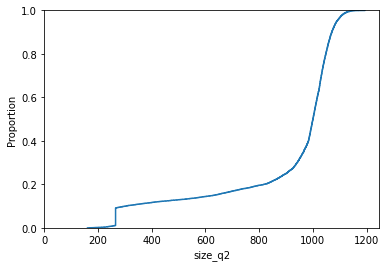

In [48]:
sns.ecdfplot(df_small["size_q2"])
plt.xlim(xmin=0)

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


for col_y in cols_y:
    df_small = df_small[~pd.isna(df_small[col_y])]
    X = df_small[cols_x].to_numpy()
    y = df_small[col_y]
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    scores = cross_val_score(regr, X, y, scoring='neg_root_mean_squared_error', cv=5)
    print(f"{col_y}: Average score: {scores.mean()} and Std dev: {scores.std()}")

framesPerSecond: Average score: -2.128873364359706 and Std dev: 0.3644806359023766
[bytesReceived_in_bits/s]: Average score: -44365.05892680508 and Std dev: 5912.062925823021
freezeCount*: Average score: -0.20953376060917406 and Std dev: 0.025870749292422005
totalFreezesDuration*: Average score: -0.14645999899643627 and Std dev: 0.09990428826875998


<AxesSubplot:xlabel='udp.length', ylabel='Proportion'>

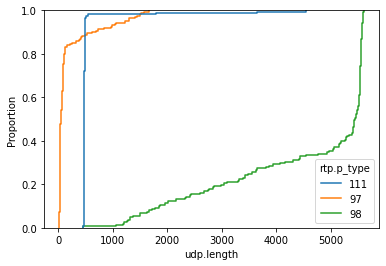

In [22]:
sns.ecdfplot(data=df_grp, x="udp.length", hue="rtp.p_type")

In [31]:
df_net2 = df_net1[df_net1['rtp.p_type'] == '111']
df_net2['udp.length'].describe(percentiles=[0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    86509.000000
mean        70.906229
std         19.059969
min         51.000000
5%          51.000000
10%         51.000000
25%         51.000000
50%         82.000000
75%         82.000000
90%         98.000000
95%         98.000000
99%         98.000000
max        120.000000
Name: udp.length, dtype: float64

In [34]:
df_net2 = df_net1[df_net1['rtp.p_type'] == '98']
df_net2['udp.length'].describe(percentiles=[0.001, 0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    729672.000000
mean        941.641510
std         210.244051
min          92.000000
0.1%        150.000000
5%          590.000000
10%         673.000000
25%         798.000000
50%        1005.000000
75%        1105.000000
90%        1167.000000
95%        1191.000000
99%        1211.000000
max        1232.000000
Name: udp.length, dtype: float64